# Portland Data Analyst Job Description Text Analytics

Importing the libraries which are going to be used to perform a quick scrape of Glassdoor. I goal is to predict the salary of a job by using its job description. Next I want to look at which skills are most prevalent in job postings then look at how much each skills contributes to salary. 

In [1]:
import json
import time
import math
import unicodecsv as csv
from lxml import html, etree
from glassdoor_scraper import get_job_posts
import re
import requests
import bs4
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# Scraping our Job Posting Data

In [2]:
# Set the keyword and location for Job and Location
keyword = "Data Analyst"
keyword = keyword.replace(" ", '+')
place = "Portland"

In [3]:
# jobs = get_job_posts(keyword, place)
# jobs.to_csv('portland-senior-data-analysis.csv')

Used get_job_posts to get 'Senior Data Analyst' roles in Portland, OR from Glassdoor. You can view the code for this scraper in the glassdoor.py file. 

In [15]:
# Read csv into Pandas DF
senior_jobs = pd.read_csv(
    'portland-senior-data-analysis.csv', encoding='latin')

# Replace the comma in the salary and convert to float
senior_jobs['Salary'] = senior_jobs['Salary'].str.replace(
    ",", "").astype(float)

# Drop Unnamed Index Column
senior_jobs.drop(columns=['Unnamed: 0', 'Rating'], inplace=True)
senior_jobs['Description'] = senior_jobs['Description'].str.lower()
#Removing Outliers
senior_jobs = senior_jobs[senior_jobs['Salary'] >= 70000]
# Preview data
print(f"Shape: {senior_jobs.shape}")
print(f"\nNull Count \n {senior_jobs.isnull().sum()}")
senior_jobs.head(5)

Shape: (105, 5)

Null Count 
 Company        0
Job Title      0
Location       0
Salary         0
Description    0
dtype: int64


,Company,Job Title,Location,Salary,Description
2,Kongregate,Senior Data Analyst,"Portland, OR",93000.0,the insights and analytics team is responsibl...
3,Nike,Senior Business Data Analyst,"Beaverton, OR",98000.0,"at nike, we serve athletes. fueled by the insi..."
5,ProKarma,Data Scientist,"Portland, OR",136000.0,description prokarma is currently seeking a d...
7,Nike,Senior Data Analyst Marketplace Analytics Mult...,"Beaverton, OR",107000.0,"at nike, we serve athletes. fueled by the ins..."
8,Simple,Senior Product Data Analyst,"Portland, OR",84000.0,the company: we're a tech company that's chan...


# Exploratory Data Analysis

## Mean Salary for Postings

C:\Users\anorum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


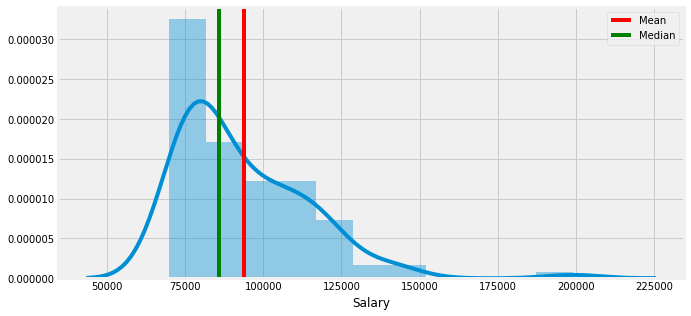

Mean Salary : $93695.24
Median Salary : $86000.0


In [16]:
fig = plt.figure(figsize=(10, 5))
sns.distplot(senior_jobs['Salary'].dropna())
plt.axvline(
    round(np.mean(senior_jobs['Salary'].dropna()), 2), label='Mean', c='red')
plt.axvline(
    round(np.median(senior_jobs['Salary'].dropna()), 2), label='Median', c='green')
plt.legend()
plt.show()
print(f"Mean Salary : ${round(np.mean(senior_jobs['Salary'].dropna()),2)}")
print(f"Median Salary : ${round(np.median(senior_jobs['Salary'].dropna()),2)}")

The mean salary for a Data Analyst Job is about 85k a year. Compared to a median of 80k meaning our distribution is slightly positively skewed with a few outliers on the higher end. However, this data also includes many non senior level positions. Lets filter for senior only and look at that distribution.

## Senior Only Data Analyst Salary

C:\Users\anorum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


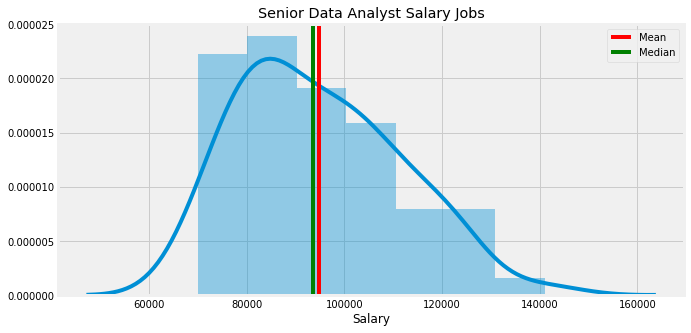

Mean Salary : $94870.97
Median Salary : $93500.0


In [17]:
senior_only = senior_jobs[senior_jobs['Job Title'].str.contains('Senior')]

fig = plt.figure(figsize=(10, 5))
sns.distplot(senior_only['Salary'].dropna())
plt.axvline(
    round(np.mean(senior_only['Salary'].dropna()), 2), label='Mean', c='red')
plt.axvline(
    round(np.median(senior_only['Salary'].dropna()), 2), label='Median', c='green')
plt.title('Senior Data Analyst Salary Jobs')
plt.legend()
plt.show()
print(f"Mean Salary : ${round(np.mean(senior_only['Salary'].dropna()),2)}")
print(f"Median Salary : ${round(np.median(senior_only['Salary'].dropna()),2)}")


## Mean Salary by Company
Who pays the the most on average?

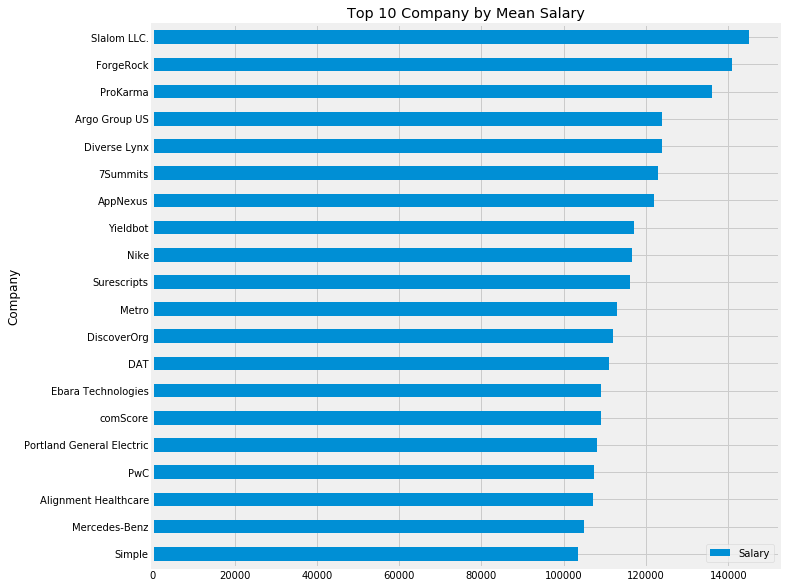

In [18]:
senior_jobs.pivot_table(index="Company", values="Salary", aggfunc="mean").dropna().sort_values(by="Salary")[-20:]. \
    plot.barh(figsize=(10, 10), title='Top 10 Company by Mean Salary')
plt.show()

Looks like the highest paying companies are a mix between Tech, Insurance, and Consulting

## Job Posting Count By Company
Whos hiring the most positions?

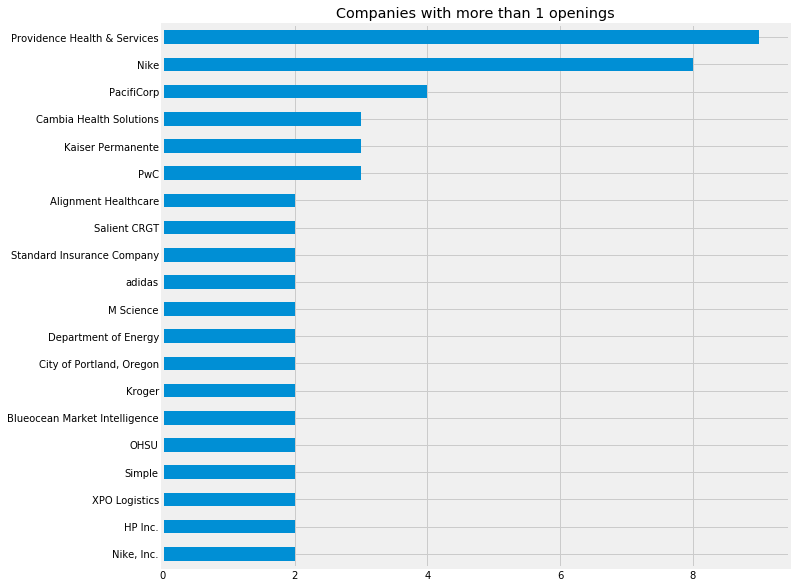

In [19]:
senior_jobs['Company'].value_counts()[senior_jobs['Company'].value_counts() > 1].sort_values(
).plot.barh(figsize=(10, 10), title='Companies with more than 1 openings', color='#008FD5')

Unsurprisingly the biggest companies in Oregon are hiring the most. Worksource is a employment contractor and do a lot of hiring the area for a wide variety of companies. Nike is second with nearly double the amount of posting as the next closest of consultant VanderHouwen and insurance company Providence.
This aligns with the overall job market of Portland, OR.

# Cleaning Job Descriptions with NLTK
Below are functions to remove stopwords, punctuation, and then lematize the words in the job descriptions. The reason we do this is to remove irrelevant information in hopes that we can get more concentrated job descriptions

In [20]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer


# Remove Common English words and common Job Description words that don't add much value

def remove_stopwords(desc):
    sw = set(stopwords.words('english'))

    # Add stopwords that are common in job descriptions that provide much value
    sw.update(['description', 'job', 'overview', 'employer', 'employee', 'experience', 'work', 'skills',
               'analyst', 'analysis', 'position', 'years', 'required', 'preferred', 'new',
               'team', 'business', 'information', 'ability', 'related', 'technical', 'data', 'requirements', 'management',
               'including', 'strong', 'knowledge', 'provide', 'degree', 'bachelor', 'masters',
               'multiple', 'teams', 'opportunity'])

    return [item for item in desc if item not in sw]


# Remove all punctuation from the job description
def remove_punc(desc):
    # Remove Punctuation
    punctokenizer = RegexpTokenizer(r'\w{3,}')
    return punctokenizer.tokenize(desc)


# Lemmatize the job descriptions
def lem_desc(desc):
    lem = WordNetLemmatizer()
    lemdesc = []

    for w in desc:
        lemdesc.append(lem.lemmatize(w))

    return lemdesc

In [21]:
# Apply our functions above
descriptions = senior_jobs['Description'].apply(
    remove_punc).apply(remove_stopwords).apply(lem_desc)

## Looking at Bi-Grams to combine common words
Lets use bigrams to look at words that are commonly shown together. I will take this approach as opposed to Part of Speech tagging and chunking, because there are specific skill combos I want to look at.

In [22]:
# Create a flat list of all the job descriptions
bg = [word for singledescription in descriptions.tolist()
      for word in singledescription]

# Create a bigram tuples and loop through them to show our most common 50 bigrams
bgs = nltk.bigrams(bg)
fdist = nltk.FreqDist(bgs)
fdist.most_common(50)

[(('health', 'care'), 59),
 (('national', 'origin'), 50),
 (('sexual', 'orientation'), 46),
 (('computer', 'science'), 45),
 (('problem', 'solving'), 43),
 (('supply', 'chain'), 40),
 (('cross', 'functional'), 39),
 (('veteran', 'status'), 37),
 (('gender', 'identity'), 37),
 (('race', 'color'), 36),
 (('without', 'regard'), 36),
 (('regard', 'race'), 34),
 (('software', 'development'), 32),
 (('qualified', 'applicant'), 32),
 (('essential', 'function'), 31),
 (('receive', 'consideration'), 31),
 (('applicant', 'receive'), 30),
 (('orientation', 'gender'), 30),
 (('internal', 'external'), 30),
 (('color', 'religion'), 28),
 (('employment', 'without'), 28),
 (('consideration', 'employment'), 27),
 (('combination', 'education'), 25),
 (('machine', 'learning'), 24),
 (('affirmative', 'action'), 24),
 (('equal', 'employment'), 23),
 (('equivalent', 'combination'), 23),
 (('full', 'time'), 22),
 (('policy', 'procedure'), 22),
 (('subject', 'matter'), 22),
 (('power', 'cost'), 22),
 (('backg

In [23]:
# Using data above and knowledge to combine skill words
def combine_skills(s):
    s = s.replace("health care", "health_care")
    s = s.replace("software development", "software_development")
    s = s.replace("decision making", "decision_making")
    s = s.replace("customer service", "customer_service")
    s = s.replace("finance accounting", "accounting_finance")
    s = s.replace("accounting finance", "accounting_finance")
    s = s.replace("end user", "end_user")
    s = s.replace("business intelligence", "business_intelligence")
    s = s.replace(" c ", " c_plus_plus ")
    s = s.replace("c++", "c_plus_plus")
    s = s.replace("ml", "machine_learning")
    s = s.replace("machine learning", "machine_learning")
    s = s.replace("amazon", "aws")
    s = s.replace("big data", "big_data")
    s = s.replace("statistical modeling", "statistics")
    s = s.replace("databases", "database")
    s = s.replace("communication", "communication_skills")
    s = s.replace("power bi", "power_bi")
    s = s.replace("google analytics", "google_analytics")
    s = s.replace("qlikview", "qlik")
    s = s.replace("ab testing", "ab_testing")
    s = s.replace("linear algebra", "linear_algebra")
    s = s.replace("jupyter", "jupyter_notebook")
    s = s.replace("problem solver", "problem_solving")
    s = s.replace("problem solving", "problem_solving")
    s = s.replace("critical thinking", "critical_thinking")
    s = s.replace("think critically", "critical_thinking")
    s = s.replace(" r ", "r_programming")
    s = s.replace("process improvement", "process_improvement")
    s = s.replace("software development", "software_development")
    s = s.replace("computer science", "computer_science")
    return s

In [24]:
descriptions = senior_jobs['Description'].apply(combine_skills).apply(
    remove_punc).apply(remove_stopwords).apply(lem_desc)

# Most Common Words in Job Descriptions
After cleaning the job descriptions, lets generate a bar chart showing the top 30 most common words

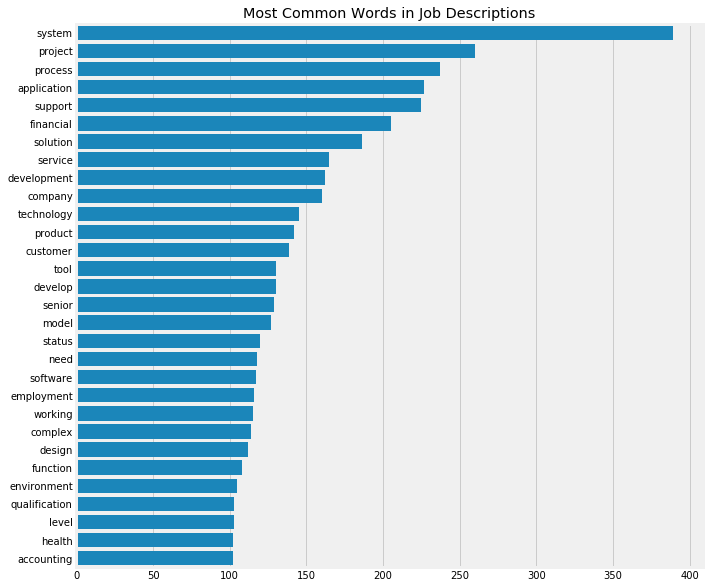

In [25]:
most_common_words = nltk.FreqDist([word for singledescription in descriptions.tolist()
                                   for word in singledescription]).most_common(30)

x_freq = [x[0] for x in most_common_words]
y_freq = [y[1] for y in most_common_words]

plt.figure(figsize=(10, 10))
sns.barplot(y=x_freq, x=y_freq, color='#008FD5')
plt.title('Most Common Words in Job Descriptions')
plt.show()

# Most Common Skills in Job Descriptions
Generating a list of skills relevant to a data analyst and seeing the most common.

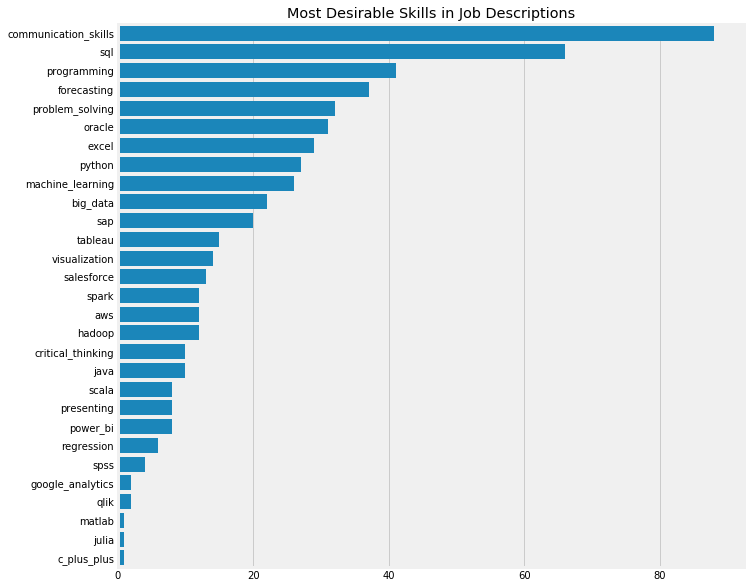

In [47]:
programming = ['hadoop', 'django', 'flask', 'r', 'python', 'c_plus_plus', 'java',
               'julia', 'sas', 'sql', 'matlab', 'scala', 'programming', 'vba', 'ruby', 'spark', 'spss', 'r_programming', 'big_data']
visualization = ['visualization', 'd3js', 'tableau', 'matplotlib',
                 'power_bi', 'plotly', 'qlik', 'datawrapper', 'highscharts', 'dash']
software = ['jupyter_notebook', 'excel', 'google_analytics',
            'sap', 'salesforce', 'oracle', 'docker', 'aws']
maths = ['linear_algebra', 'statistics',
         'machine_learning', 'forecasting', 'regression']
soft_skills = ['communication_skills',
               'problem_solving', 'critical_thinking', 'presenting']

skills = programming + visualization + software + maths + soft_skills

most_common_skills = nltk.FreqDist([word for singledescription in descriptions.tolist()
                                    for word in singledescription if word in skills]).most_common(30)

x_freq = [x[0] for x in most_common_skills]
y_freq = [y[1] for y in most_common_skills]

plt.figure(figsize=(10, 10))
sns.barplot(y=x_freq, x=y_freq, color='#008FD5')
plt.title('Most Desirable Skills in Job Descriptions')
plt.show()

Although this list is biased towards skills I was able to think of (no doubt I missed a few) it shows the skills most in demand for data analyst in Portland are SQL, Forecasting, Excel, Stats, and Python. Also, kind of nice to see Oracle so high as I work for them.

# Running a Gradient Boosting Regressor

## Preparing Job Descriptions for Graident Boosting Regressor

In [27]:
# Lets set a new feature with the cleaned description
senior_jobs['Description_clean'] = descriptions.str.join(' ')

In [28]:
senior_jobs.isnull().sum()

Company              0
Job Title            0
Location             0
Salary               0
Description          0
Description_clean    0
dtype: int64

In [29]:
print(senior_jobs.shape)
# Drop Nulls
senior_jobs = senior_jobs.dropna(subset=['Salary'])

# Drop low salary due to data error
senior_jobs = senior_jobs[senior_jobs['Salary'] > 1000]

print(senior_jobs.shape)

(105, 6)
(105, 6)


In [30]:
X = np.array(senior_jobs['Description_clean'])
y = np.array(senior_jobs['Salary'])

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

## TF IDF Vectorization for Job Description Features

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df=5).fit(X_train)
vect_test = TfidfVectorizer(min_df=5).fit(X_test)

X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

## Gradient Boosting Algorithm with TFIDF Features

C:\Users\anorum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RMSE: 19363.6771


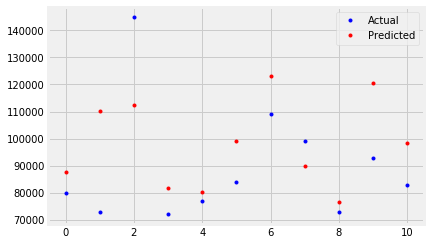

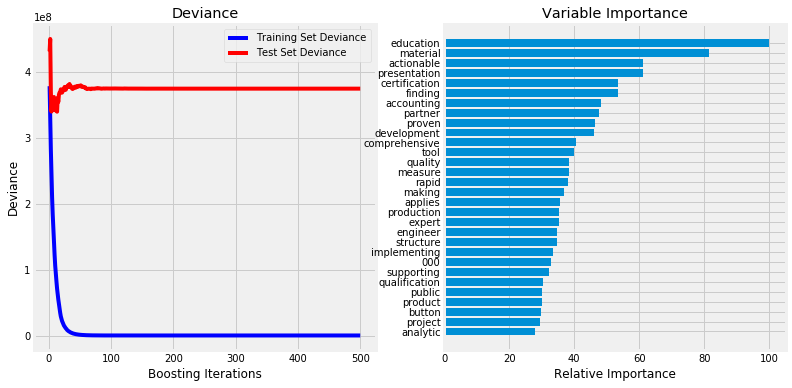

In [33]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train_vectorized, y_train)
mse = math.sqrt(mean_squared_error(y_test, clf.predict(X_test_vectorized)))
print("RMSE: %.4f" % mse)
plt.plot(y_test, 'b.', label='Actual')
plt.plot(clf.predict(X_test_vectorized), 'r.', label='Predicted')
plt.legend()
plt.show()

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test_vectorized)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[:30].shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][-30:], align='center')
plt.yticks(pos, pd.Series(vect.get_feature_names())[sorted_idx][-30:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

An RMSE of 19k is okay, but lets see if we do a simple Count Vectorized if we can improve this.

## Count Vectorized for Job Description Features

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer().fit(X_train)
cvect_test = CountVectorizer().fit(X_test)
X_train_cvectorized = vect.transform(X_train)
X_test_cvectorized = vect.transform(X_test)

## Gradient Boosting Regressor with Count Vectorized Features

RMSE: 17816.5895


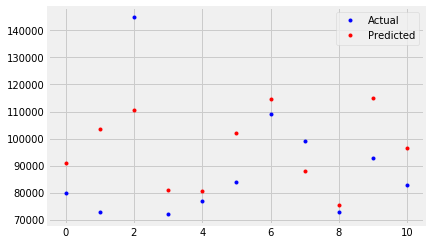

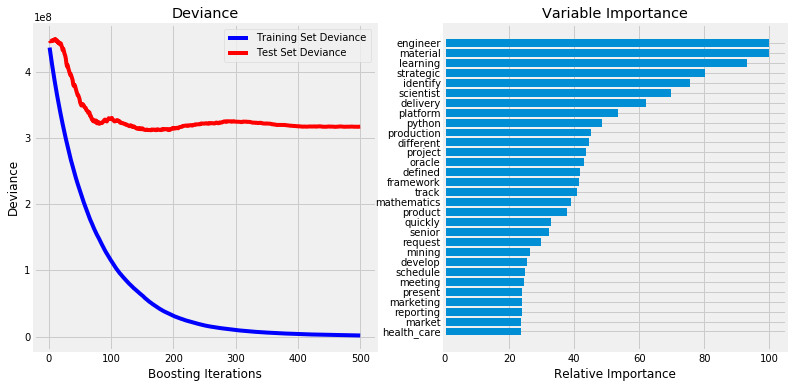

In [35]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train_cvectorized, y_train)
mse = math.sqrt(mean_squared_error(y_test, clf.predict(X_test_cvectorized)))
print("RMSE: %.4f" % mse)
plt.plot(y_test, 'b.', label='Actual')
plt.plot(clf.predict(X_test_cvectorized), 'r.', label='Predicted')
plt.legend()
plt.show()

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test_cvectorized)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[:30].shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx][-30:], align='center')
plt.yticks(pos, pd.Series(vect.get_feature_names())[sorted_idx][-30:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The RMSE is basically identical. Lets try a Support Vector Machine

# Support Vector Machine

RMSE: 21292.3375


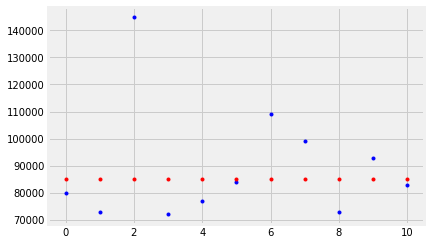

In [36]:
from sklearn.svm import SVC


clf = SVC()
clf.fit(X_train_vectorized, y_train)

# predict and evaluate predictions
mse = math.sqrt(mean_squared_error(y_test, clf.predict(X_test_vectorized)))
print("RMSE: %.4f" % mse)

plt.plot(y_test, 'b.')
plt.plot(clf.predict(X_test_vectorized), 'r.')
plt.show()

The Support Vector Machine just predicted the mean salary for all predictions resulting the baseline RMSE of 20,371.

# Linear Regression
Lets just go back to basics and run a simple Linear Regression model.

In [37]:
from sklearn.linear_model import LinearRegression

RMSE: 13864.1006


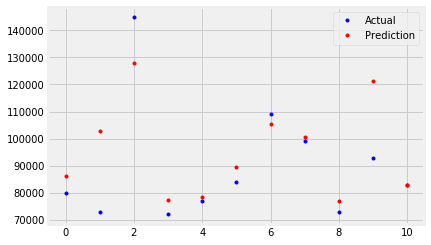

In [38]:
lr = LinearRegression()
lr.fit(X_train_vectorized, y_train)
mse = math.sqrt(mean_squared_error(y_test, lr.predict(X_test_vectorized)))
print("RMSE: %.4f" % mse)
plt.plot(y_test, 'b.', label='Actual')
plt.plot(lr.predict(X_test_vectorized), 'r.', label='Prediction')
plt.legend()
plt.show()

Suprisingly, the LInear Regression model has the best RMSE so we will use this model to have some fun predicting salaries below.

## Feature Importance of Linear Regression
Lets look at which features we're the most important in predicting salaries in the Linear Regression model

In [39]:
feature_importance = sorted(zip(vect.get_feature_names(), lr.coef_),
                            key=lambda x: x[1], reverse=True)

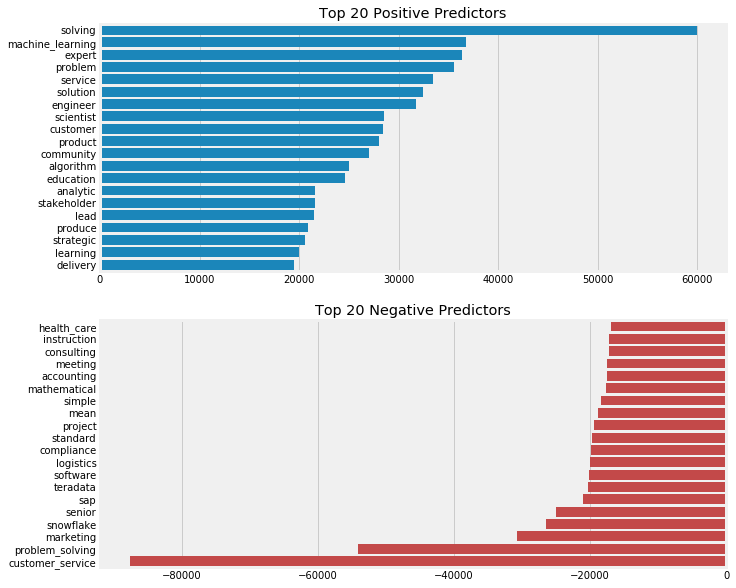

In [40]:
x_imp = [x[0] for x in feature_importance]
y_imp = [y[1] for y in feature_importance]

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.barplot(y=x_imp[:20], x=y_imp[:20], color='#008FD5')
plt.title('Top 20 Positive Predictors')

plt.subplot(2, 1, 2)
sns.barplot(y=x_imp[-20:], x=y_imp[-20:], color='#D73535')
plt.title('Top 20 Negative Predictors')


plt.show()

Based on above having machine learning skills and getting the title of Data Scientist is very important for high salaries as a Data Analyst. Other words like Expert, Engineer, Solution, Advanced, Platform, and Product lead me to believe that Data Analyst who can create data products are the most highly paid.

While on the other end of the spectrum it appears that data analyst in the fields of web, banking, marketing, and logistics are not as highly paid as other data analyst.

# Saving TFIDF and LR model using Pickle

In [41]:
import pickle

pickle.dump(lr, open('lr_desc_model.sav', 'wb'))
pickle.dump(vect, open('tfidf.sav', 'wb'))

# Finalizing it all into one function a function
The function below takes in an input of a job description as a string. Cleans the string to combine skills words (see above), remove punctuation, remove stopwords, TF IDF vectorizes the string into features, then uses the Linear Regression model to make a salary predictions.

In [42]:
def clean_vect_pred(desc):

    # Load Linear Regression Model and TF IDF vectorizer
    lr = pickle.load(open('lr_desc_model.sav', 'rb'))
    vect = pickle.load(open('tfidf.sav', 'rb'))

    # Apply all cleaning functions
    clean = np.asarray(pd.Series(desc).str.lower().apply(combine_skills).apply(
        remove_punc).apply(remove_stopwords).apply(lem_desc).str.join(' '))

    # Vectorize cleaned job description
    clean_vect = vect.transform(clean)

    # Use Linear Regression model to predict Salary
    prediction = lr.predict(clean_vect)

    # Round salary to 2 decimals and return result
    return round(prediction[0], 2)

In [43]:
nike_desc = """ Sr. Cost Data Analyst 

Department Description: Global Supplier Management

Overview:
A key enabler for Oracle’s sustained growth across all Cloud businesses is the infrastructure necessary to support Oracle’s public cloud data centers as well as customer On-Premise deployments.  Oracle’s Supply Chain Operations organization is looking for individuals who want to directly participate in the cloud technology revolution and help build, scale and optimize a world-class supply chain.

The Cost Data Analyst will be a key member of the Cost Management & Strategy team, who will advance GSM’s cost management capabilities by developing cost models, databases and key processes.  They will leverage Fusion & Data Visualization apps to further optimize cost and deliver increased value.   


Key Focus Areas:
Cost Data Management 
•	Price Database
•	Cost Models
•	Data Visualization
•	Supply Chain Maps
•	Spend Categorization
•	Spend Performance Management
•	Cost Management Tools
•	Organization Capabilities/Utilization


Primary Responsibilities: 

•	Develop cost models, databases and processes that provide step-function improvement to GSM’s cost management capabilities through expanded use of cost data information, analytics, models and visualization. 
•	Drive the development of all key processes & toolsets required to enable rapid(on-demand) cost data history and forecast by key groupings such as Oracle part number, supplier part number, commodity, supplier, sub-assembly, product level, etc.  
o	Develop and partner with key SCO stakeholders to ensure the creation of a robust cost database, that enables active tracking of cost management 
•	Subject Matter Expert for the Fusion Data Visualization toolset; drives deep visual insights into GSM’s cost management performance and effectiveness.  Utilizes the Data Visualization tool-set to provide key insights on new potential areas to drive out cost. 
•	Presenting critical data in a format that is immediately useful to answer questions about the inputs and outputs of Cost Management systems and improving their performance.
•	Develop and reimagine the creation and use of Supply Chain Maps to further enable cost management analytics.  Leverage existing Oracle Fusion product suite. 
•	Drive improved GSM cost management performance by ensuring ready access to all required cost data.  Partner with key BU internal customers and SCO stakeholders on key cost data information needs and requirements.  
•	Enable improvements to Spend Management effectiveness by driving the use of spend categories (commodity codes) in Fusion.  Drive the required process changes and training with key internal stakeholders to ensure it becomes process of record. 
•	Partner with Finance on standard cost process and performance as required. Ensure availability and alignment on cost savings, cost avoidance and purchase price variance. 
•	Own strategy for GSM cost data requirements, assess and validate existing tools and processes.  Drive optimized use of Fusion, ensure attribute optimization.  
•	Support the development and automation of required metrics.


Preferred Qualifications:
•	5+ years of Operations, Supply Chain, Procurement and/or Finance experience in a global Operations group, and a BS/BA degree in Business, Finance, Engineering or Computer Science.
•	Proficiency with tools commonly used for data analysis and visualization such as Oracle Data Visualization, R, Python (Matplotlib, ggplot,etc). 
•	Utilizing code (Python, R, Scala, SQL etc.) for analyzing data and building statistical and machine learning models and algorithms
•	Experience with databases and familiarity with data visualization tools/frameworks as well as notebooks.
•	Exposure to business intelligence tools such as Oracle, Tableau, Business Objects, etc.
•	High proficiency in Microsoft Office, especially Excel, and data import methodologies; SQL and ODBC knowledge preferred
•	Data organization and management skills. Technical expertise with data models, database design development, and data mining
•	Strong business acumen, with a solid understanding of core supply chain concepts and processes.  Has a strong desire to learn, and an inquisitive mind.
•	Candidate must be confident, self-motivated, and driven to deliver business results. Must be comfortable dealing directly with executives and putting together executive level presentations. 
Excellent oral and written communication skills and a proven ability to work effectively with both internal and external stakeholders.
Must have strong organizational skills and be comfortable multi-tasking in a fast-paced, dynamic, deadline-driven environment. 
Must have a team first mindset 


"""

In [44]:
print(f"\n\nPredicted Salary: ${clean_vect_pred(nike_desc)}")



Predicted Salary: $95287.52


![NN](./GlassdoorActual.png)

Actual Predicted Salary on Glassdoor is 83k - 108k with the actual as $95,000 so not too bad that the simple linear regression model predicts within 10k

# Try it Yourself

The Predicted Salary will output below

In [45]:
from IPython.display import display
from ipywidgets import widgets

outputText = widgets.Text()
outputText

Text(value='')

Enter your job description below and click the submit button

In [46]:
def button_clicked(b):
    outputText.value = f"\n\nPredicted Salary: ${clean_vect_pred(user_description.value)}"
    print(f"\n\nPredicted Salary: ${clean_vect_pred(user_description.value)}")

button = widgets.Button(description="Submit")
user_description = widgets.Textarea()
print('Enter Job Description and Click Submit:')
display(user_description)
display(button)

button.on_click(button_clicked)

Enter Job Description and Click Submit:


Textarea(value='')

Button(description='Submit', style=ButtonStyle())